# Import dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import backend as K

In [2]:
from PIL import Image, ImageDraw, ImageFont

In [3]:
import random
import os

# Set memory growth

In [4]:
gpus = tf.config.list_physical_devices('GPU')

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Data preparation

In [5]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

4422102/4422102 [==============================] - 1s 0us/step


((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [7]:
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

In [9]:
train_images = train_images / 255.0
test_images = test_images / 255.0

6


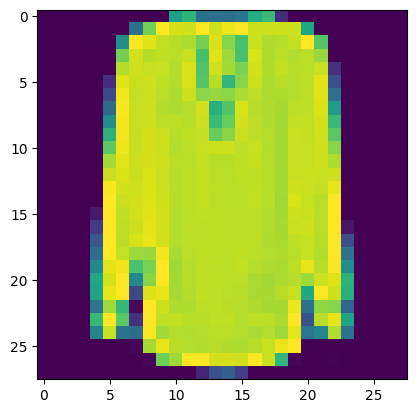

In [22]:
index = int(random.random() * train_images.shape[0])

plt.imshow(train_images[index])
print(train_labels[index])

In [39]:
def create_pairs(x, digit_indices):
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    
    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
            
    return np.array(pairs), np.array(labels)

In [40]:
def create_pairs_on_set(images, labels):
    
    digit_indices = [np.where(labels == i)[0] for i in range(10)]
    pairs, y = create_pairs(images, digit_indices)
    y = y.astype('float32')
    
    return pairs, y

In [41]:
def show_image(image):
    plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.grid(False)
    plt.show()

In [42]:
train_pairs, train_y = create_pairs_on_set(train_images, train_labels)
test_pairs, test_y = create_pairs_on_set(test_images, test_labels)

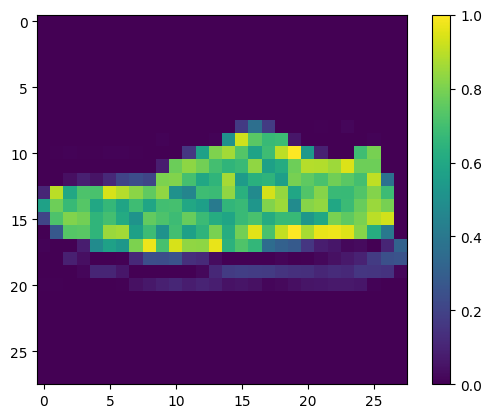

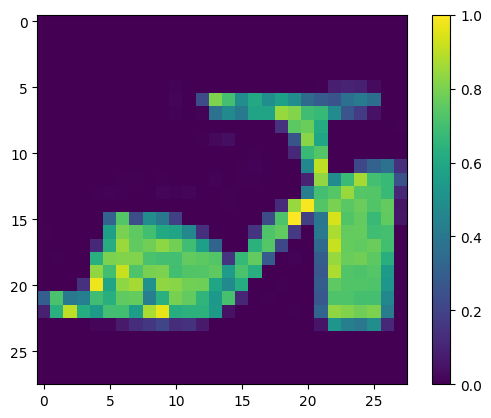

0.0


In [58]:
# array index
this_pair = random.randrange(0, train_pairs.shape[0])

# show images at this index
show_image(train_pairs[this_pair][0])
show_image(train_pairs[this_pair][1])

# print the label for this pair
print(train_y[this_pair])

In [59]:
train_pairs.shape

(119980, 2, 28, 28)

In [74]:
def create_base_model(img_shape = (28, 28, )):
    input_layer = tf.keras.Input(shape = img_shape, name = 'base_input')
    x = tf.keras.layers.Flatten(name = 'flatten_input')(input_layer)
    x = tf.keras.layers.Dense(128, activation='relu', name = 'first_base_dense')(x)
    x = tf.keras.layers.Dropout(0.1, name = 'first_dropout')(x)
    x = tf.keras.layers.Dense(128, activation='relu', name = 'second_base_dense')(x)
    x = tf.keras.layers.Dropout(0.1, name = 'second_dropout')(x)
    x = tf.keras.layers.Dense(128, activation='relu', name = 'third_base_dense')(x)
    return tf.keras.Model(inputs=input_layer, outputs = x)

In [75]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

In [76]:
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [80]:
def create_model(img_shape = (28, 28,)):
    base_model = create_base_model()
    input_a = tf.keras.Input(shape = img_shape, name = 'left_input')
    vec_output_a = base_model(input_a)
    
    input_b = tf.keras.Input(shape = img_shape, name = 'right_input')
    vec_output_b = base_model(input_b)
    
    output = tf.keras.layers.Lambda(euclidean_distance, name = 'output_layer', 
                                    output_shape= eucl_dist_output_shape,
                                   )([vec_output_a, vec_output_b])
    return tf.keras.Model(inputs = [input_a, input_b], outputs = output)

model = create_model()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 left_input (InputLayer)        [(None, 28, 28)]     0           []                               
                                                                                                  
 right_input (InputLayer)       [(None, 28, 28)]     0           []                               
                                                                                                  
 model_1 (Functional)           (None, 128)          133504      ['left_input[0][0]',             
                                                                  'right_input[0][0]']            
                                                                                                  
 output_layer (Lambda)          (None, 1)            0           ['model_1[0][0]',          

In [81]:
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return K.mean(y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss

In [82]:
optimizer = tf.keras.optimizers.RMSprop()

model.compile(optimizer = optimizer, loss = contrastive_loss_with_margin(margin = 1))

In [84]:
history = model.fit([train_pairs[:, 0], train_pairs[:, 1]], train_y, epochs= 20, batch_size= 128, 
                    validation_data=([test_pairs[:, 0], test_pairs[:, 1]], test_y))

Epoch 1/20
938/938 [==============================] - 27s 15ms/step - loss: 0.0614 - val_loss: 0.0674
Epoch 2/20
938/938 [==============================] - 8s 9ms/step - loss: 0.0603 - val_loss: 0.0662
Epoch 3/20
938/938 [==============================] - 8s 8ms/step - loss: 0.0590 - val_loss: 0.0653
Epoch 4/20
938/938 [==============================] - 8s 8ms/step - loss: 0.0580 - val_loss: 0.0657
Epoch 5/20
938/938 [==============================] - 8s 9ms/step - loss: 0.0573 - val_loss: 0.0646
Epoch 6/20
938/938 [==============================] - 11s 12ms/step - loss: 0.0565 - val_loss: 0.0690
Epoch 7/20
938/938 [==============================] - 7s 8ms/step - loss: 0.0557 - val_loss: 0.0661
Epoch 8/20
938/938 [==============================] - 8s 8ms/step - loss: 0.0555 - val_loss: 0.0671
Epoch 9/20
938/938 [==============================] - 10s 10ms/step - loss: 0.0548 - val_loss: 0.0649
Epoch 10/20
938/938 [==============================] - 9s 10ms/step - loss: 0.0545 - val_loss:

In [86]:
loss = model.evaluate(x= [test_pairs[:, 0], test_pairs[:, 1]], y= test_y)

625/625 [==============================] - 3s 5ms/step - loss: 0.0681


In [87]:
loss

0.06813298165798187

In [88]:
def compute_accuracy(y_true, y_pred):
    pred = y_pred.ravel() > 0.5
    return np.mean(pred == y_true)

In [93]:
compute_accuracy(train_y[:256],model.predict([train_pairs[:256, 0], train_pairs[:256, 1]]))

8/8 [==============================] - 2s 8ms/step


0.08984375